# VGG16 預測貓狗照片
* 遷移學習 TL: Transfer Learning
* 取得VGG16的CNN並固定原始訓練參數，再自建MLP
* 所有的訓練資料都要轉成 numpy array，不可以餵list, DataFrame等格式

```python
import glob
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input
```

In [1]:
import glob
import pandas as pd
# 先不讀取圖片，真的要訓練的時候才讀
catf = glob.glob("train/cat.*.jpg") # list
catans = [0]*len(catf) # list
dogf = glob.glob("train/dog.*.jpg")
dogans = [1]*len(dogf)
df = pd.DataFrame({
    "path":catf + dogf,
    "ans":catans + dogans
})

print(type(catf))
print(type(catans))
df


<class 'list'>
<class 'list'>


,path,ans
0,train/cat.5077.jpg,0
1,train/cat.2718.jpg,0
2,train/cat.10151.jpg,0
3,train/cat.3406.jpg,0
4,train/cat.4369.jpg,0
...,...,...
24995,train/dog.9316.jpg,1
24996,train/dog.6025.jpg,1
24997,train/dog.8008.jpg,1
24998,train/dog.1992.jpg,1


### 另一個建立DataFrame的方式 (比較複雜)
```python
import glob
import pandas as pd
# 先不讀取圖片，真的要訓練的時候才讀
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("train/cat.*.jpg"):
    s = pd.Series([p,0], index=["path", "target"])
    df = df.append(s, ignore_index=True)
for p in glob.glob("train/dog.*.jpg"):
    s = pd.Series([p,1], index=["path", "target"])
    df = df.append(s, ignore_index=True)    
df
``` 

In [2]:
'''This cell is for MacOS user'''
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# https://keras.io/applications/#vgg16
# keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
# include_top -> 要不要把腦袋載入(MLP)
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224,224,3))
vgg.summary()

Using TensorFlow backend.
/Users/lenotsai/Desktop/0912_機器深度學習/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lenotsai/Desktop/0912_機器深度學習/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lenotsai/Desktop/0912_機器深度學習/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
# a list
vgg.layers

* 高斯分佈：平均是0，標準差是1
* Batch Normalization
* x_new = 資料減平均，再除以標準差 -> 把資料 x 的平均變成0，標準差變成1
* gamma -> 新標準差 ； beta -> 新的平均
* 每個特徵都做 gamma * x_new + beta

```python
tensor帶入多個張量的時候 -> model = Model(inputs=[a1, a2], outputs=[b1,b2,b3])
Model(inputs=張量, outputs=張量)

回傳值是一個函式
張量2 = Dense(256, activation="relu")(張量1)
張量3 = Dense(10,activation="softmax")(張量2)

mlp = Model(inputs=張量1, outputs=張量3)
```

In [5]:
from keras.layers import Dense, Flatten, Dropout

# VGG16的CNN不是Sequential, 因此不能使用keras.models.Sequential

for l in vgg.layers:
    l.trainable = False

from keras.layers import BatchNormalization

from keras.models import Model
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(2, activation="softmax")(x)
cnn = Model(inputs=vgg.inputs, outputs=x)
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
cnn.compile(loss="categorical_crossentropy",
           optimizer="adam",
           metrics=["accuracy"])

In [7]:
# 所有的訓練資料都要轉成 numpy array，不可以餵list, DataFrame等格式
import numpy as np

x = np.array(df["path"])
# 還未讀取圖片，此時的x是圖片路徑

y = np.array(pd.get_dummies(df["ans"]))
print(df["path"])
print('='*20)
print(x[0])
print(y[0])
print('='*20)
print(x[-1])
print(y[-1])

0         train/cat.5077.jpg
1         train/cat.2718.jpg
2        train/cat.10151.jpg
3         train/cat.3406.jpg
4         train/cat.4369.jpg
                ...         
24995     train/dog.9316.jpg
24996     train/dog.6025.jpg
24997     train/dog.8008.jpg
24998     train/dog.1992.jpg
24999    train/dog.12412.jpg
Name: path, Length: 25000, dtype: object
train/cat.5077.jpg
[1 0]
train/dog.12412.jpg
[0 1]


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =  train_test_split(x,y,test_size=0.1)
x_train[0]

'train/dog.5753.jpg'

* 一定要使用(vgg16)當初的做法
* https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
* https://github.com/keras-team/keras-applications/tree/master/keras_applications

In [9]:
# 測試: 藉由一張圖片告訴你如何處理
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input
img = load_img(x_train[0], target_size=(224,224)).convert("RGB")
img_np = np.array(img)

print(preprocess_input(img_np).shape)
preprocess_input(img_np)

(224, 224, 3)


array([[[-40.939003 , -67.779    , -70.68     ],
        [-56.939003 , -83.779    , -88.68     ],
        [-54.939003 , -86.779    , -90.68     ],
        ...,
        [-44.939003 , -59.779    , -37.68     ],
        [-45.939003 , -60.779    , -38.68     ],
        [-48.939003 , -57.779    , -39.68     ]],

       [[-50.939003 , -72.779    , -76.68     ],
        [-59.939003 , -85.779    , -90.68     ],
        [-59.939003 , -86.779    , -91.68     ],
        ...,
        [-44.939003 , -59.779    , -37.68     ],
        [-44.939003 , -59.779    , -37.68     ],
        [-46.939003 , -58.779    , -39.68     ]],

       [[-68.939    , -86.779    , -91.68     ],
        [-67.939    , -88.779    , -94.68     ],
        [-63.939003 , -87.779    , -92.68     ],
        ...,
        [-42.939003 , -59.779    , -37.68     ],
        [-42.939003 , -59.779    , -37.68     ],
        [-46.939003 , -58.779    , -39.68     ]],

       ...,

       [[-36.939003 , -52.779    , -50.68     ],
        [-3

### numpy.random.randint
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html
* numpy.random.randint(low, high=None, size=None, dtype='l')
* Return random integers from low (inclusive) to high (exclusive)

```python
>>> np.random.randint(2, size=10)
array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

>>> np.random.randint(1, size=10)
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

>>> np.random.randint(5, size=(2, 4))
array([[4, 0, 2, 1],
       [3, 2, 2, 0]])
```

In [10]:
# 測試:
batch = 20
idx = np.random.randint(0, x_train.shape[0],batch)
print('idx: ',idx)
print('idx type: ',type(idx))
print('='*50)
print('x_train.shape: ',x_train.shape)
print('x_train.shape[0]: ',x_train.shape[0])
x_train[idx]

idx:  [20664  1554 21002 13084  4153  8098   759 15683 16330  6207 18217 17537
 12981  5887  3165   805  5875  9984 20859  8505]
idx type:  <class 'numpy.ndarray'>
x_train.shape:  (22500,)
x_train.shape[0]:  22500


array(['train/dog.9130.jpg', 'train/cat.11362.jpg', 'train/dog.12471.jpg',
       'train/cat.11766.jpg', 'train/dog.7200.jpg', 'train/cat.12148.jpg',
       'train/cat.5432.jpg', 'train/dog.2007.jpg', 'train/cat.224.jpg',
       'train/dog.2654.jpg', 'train/cat.11681.jpg', 'train/dog.7257.jpg',
       'train/cat.12086.jpg', 'train/cat.12098.jpg', 'train/dog.3056.jpg',
       'train/cat.8223.jpg', 'train/cat.7440.jpg', 'train/cat.8416.jpg',
       'train/cat.529.jpg', 'train/dog.2801.jpg'], dtype=object)

In [11]:
# get_images (批次量, 圖檔list, 解答list)
def get_images (batch, x, y):
    idx = np.random.randint(0, x.shape[0],batch)
    ori_img_list=[]
    img_list=[]
    for fp in x[idx]:
        img = load_img(fp, target_size=(224,224)).convert("RGB")
        img_np = np.array(img)
        img_pre = preprocess_input(img_np)
        img_list.append(img_pre)
        ori_img_list.append(img_np)
    img_list_np = np.array(img_list)
    ori_img_list_np = np.array(ori_img_list)
    return (ori_img_list_np, img_list_np, y[idx])
# return (原圖, 預處理過後的圖, 答案)

In [12]:
# 設定計數器
counter = 0
print(counter)

0


In [13]:
counter += 1
print('本cell執行次數:',counter)


times = 5  # 這裡填入訓練次數

start = 0+ (counter-1)*times
times = times*counter
for i in range(start, times):
    imgs = get_images(10, x_train, y_train)
    result = cnn.train_on_batch(imgs[1], imgs[2])
    print("-" * 15, "times", i + 1, "-" * 15)
    print("[Train]:", result)
    # 如果時間充裕, 最好多一點
    test_imgs = get_images(10, x_test, y_test)
    test_result = cnn.test_on_batch(test_imgs[1], test_imgs[2])
    print("[Validate]:", test_result)
    

本cell執行次數: 1
--------------- times 1 ---------------
[Train]: [1.0473335, 0.3]
[Validate]: [0.7551142, 0.7]
--------------- times 2 ---------------
[Train]: [1.060309, 0.7]
[Validate]: [3.305884, 0.7]
--------------- times 3 ---------------
[Train]: [2.8266635, 0.7]
[Validate]: [7.5032706, 0.4]
--------------- times 4 ---------------
[Train]: [5.420767, 0.6]
[Validate]: [1.7342008, 0.8]
--------------- times 5 ---------------
[Train]: [1.6277937, 0.9]
[Validate]: [3.223929, 0.8]


In [14]:
cnn.predict(test_imgs[1])


array([[6.3141814e-19, 1.0000000e+00],
       [9.9999988e-01, 1.0742482e-07],
       [1.0000000e+00, 2.6466582e-10],
       [3.6416533e-24, 1.0000000e+00],
       [3.8904227e-09, 1.0000000e+00],
       [9.9691027e-01, 3.0897979e-03],
       [2.0978829e-15, 1.0000000e+00],
       [7.9574643e-18, 1.0000000e+00],
       [1.0000000e+00, 1.6874481e-09],
       [2.0214102e-32, 1.0000000e+00]], dtype=float32)

In [15]:
# answer-> one-hot
y_train

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]], dtype=uint8)

In [16]:
# return (原圖, 預處理過後的圖, 答案)[2] : array of one-hot
get_images(20, x_train, y_train)[2]

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [17]:
# 取200組測試資料看evaluate分數
test_imgs = get_images(200, x_test, y_test)
cnn.evaluate(test_imgs[1], test_imgs[2])

200/200 [==============================] - 111s 556ms/step


[1.8619373893737794, 0.8]

In [18]:
# 取50組測試資料看prediction
f = get_images(50, x_test, y_test)
pre_ = cnn.predict(f[1])
pre = pre_.argmax(axis = 1)

In [ ]:
# predict的結果是one-hot encoding
pre_

In [ ]:
pre

[ 2  5  7  9 18 19 20 25 27 28 47]


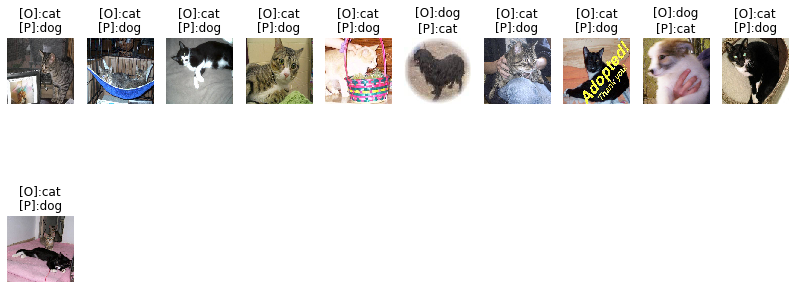

In [19]:
# 50組測試資料predict錯誤的就秀圖片出來觀察
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
labels = ["cat", "dog"]
test = f[2].argmax(axis=1)
idx = np.nonzero(pre != test)[0]
print(idx)
false_img = f[0][idx]
false_answer = test[idx]
false_pre = pre[idx]

width = 10
height = len(false_img) // width + 1
plt.figure(figsize=(14, 6))
for i, img in enumerate(false_img):
    plt.subplot(height, width, i + 1)
    t = "[O]:" + labels[false_answer[i]] + "\n[P]:" + labels[false_pre[i]]
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)